<img src="https://drive.google.com/uc?id=1YLNtm8gNsviTEnVXzfiby2VMKrc0XzLP" width="500"/>

---


# Task 1
## 1.1 Download and prepare MNIST

Download MNIST and prepare it as you see fit to be used in the following sections. Explain what you do at each step and **WHY** you do it.


In [4]:
# Add as many text and code blocks as needed to answer the question here

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))]) # The original implementation of GANs scales the data
                                                  # between [-1, 1]. We do that through the normalise transform.
                                                  # Removing 0.5 from the data scales the data from [0, 1] to [-0.5, 0.5]
                                                  # Dividing it by 0.5 scales the data from [-0.5, 0.5] to [-1, 1]

train_dataset = MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./mnist_data/', train=False, transform=transform, download=True)
#taken from lectures on day 7

## 1.2 Modify your prepared dataset as follows:

- flip horizontally half the images in both the train and test datasets.
- modify the labels to reflect if the images are original or flipped.

There are several ways to do this, and more than one right way to do it. Explain your implementation choices for these MNIST modifications.

In [26]:
def flip_half_dataset(dataset):
    images = []
    labels = []

    indices = list(range(len(dataset)))
    flip_indices = set(random.sample(indices, len(indices) // 2))

    for i, (img, label) in enumerate(dataset):
        if i in flip_indices:
            flipped_img = transforms.functional.hflip(img)
            images.append(flipped_img)
            labels.append((label, 1)) #label * 2 + 1
        else:
            images.append(img)
            labels.append((label, 0)) #label * 2

    return TensorDataset(torch.stack(images), torch.tensor(labels))



*  random.sample() to randomly select exactly half the indices to flip
*  an easy way to reflect the changes in labelling is to make labels even if they are original and odd if they are modified(flipped).



In [28]:
flip_train_dataset = flip_half_dataset(train_dataset)
flip_test_dataset = flip_half_dataset(test_dataset)

# print(f"Train dataset size: {len(flip_train_dataset)} (same as original)")
# print(f"Test dataset size: {len(flip_test_dataset)} (same as original)")

# # Check the flipping distribution
# train_labels = [flip_train_dataset[i][1].item() for i in range(len(flip_train_dataset))]
# flipped_count = sum(1 for label in train_labels if label % 2 == 1)
# print(f"Flipped images in train: {flipped_count} out of {len(flip_train_dataset)}")

## 1.3 Split the dataset

Split the data as you see fit, so that you can use it in the following sections.

Plot a few samples with their new corresponding labels.

In [29]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [30]:
train_size = int(0.8 * len(flip_train_dataset))
val_size = len(flip_train_dataset) - train_size

train_split, val_split = random_split(flip_train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(flip_test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_split)}")
print(f"Validation set size: {len(val_split)}")
print(f"Test set size: {len(flip_test_dataset)}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000


In [36]:
def denormalize(tensor):
    return (tensor * 0.5) + 0.5

def plot_samples(dataset, num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        img_np = denormalize(img).squeeze().numpy()

        # Extract from tuple: (original_digit, flip_status)
        original_digit = label[0].item()
        is_flipped = label[1].item() == 1

        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(f'Digit: {original_digit}\n{"Flipped" if is_flipped else "Original"}\nLabel: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('MNIST Samples with Original/Flipped Labels', y=1.02, fontsize=16)
    plt.show()

Original label: 0
Modified label: tensor([0, 1])
Decoded digit: tensor([0, 0])
Is flipped: tensor([False,  True])


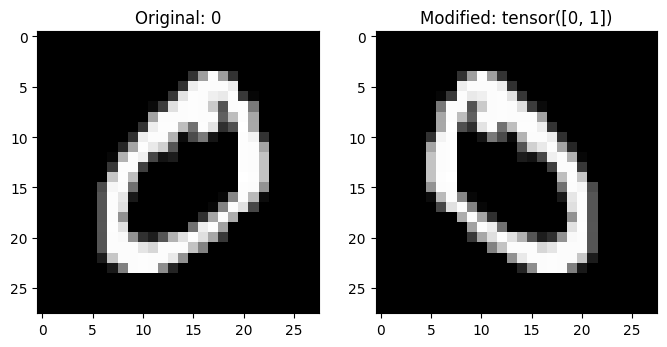

In [34]:
idx = 1  # or whatever index showed the wrong result
original_img, original_label = train_dataset[idx]
modified_img, modified_label = flip_train_dataset[idx]

print(f"Original label: {original_label}")
print(f"Modified label: {modified_label}")
print(f"Decoded digit: {modified_label // 2}")
print(f"Is flipped: {modified_label % 2 == 1}")

# Plot both to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(denormalize(original_img).squeeze(), cmap='gray')
ax1.set_title(f'Original: {original_label}')
ax2.imshow(denormalize(modified_img).squeeze(), cmap='gray')
ax2.set_title(f'Modified: {modified_label}')
plt.show()

Training Set Samples:


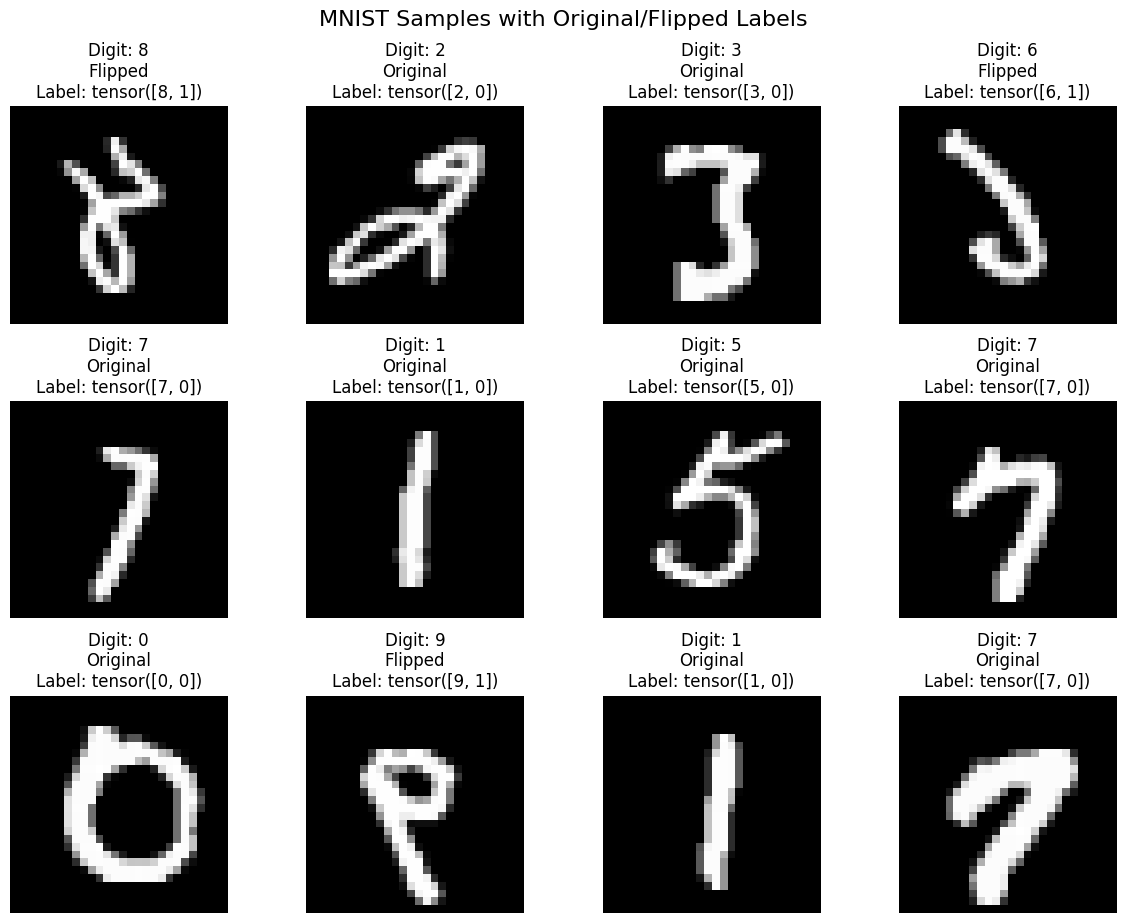


Test Set Samples:


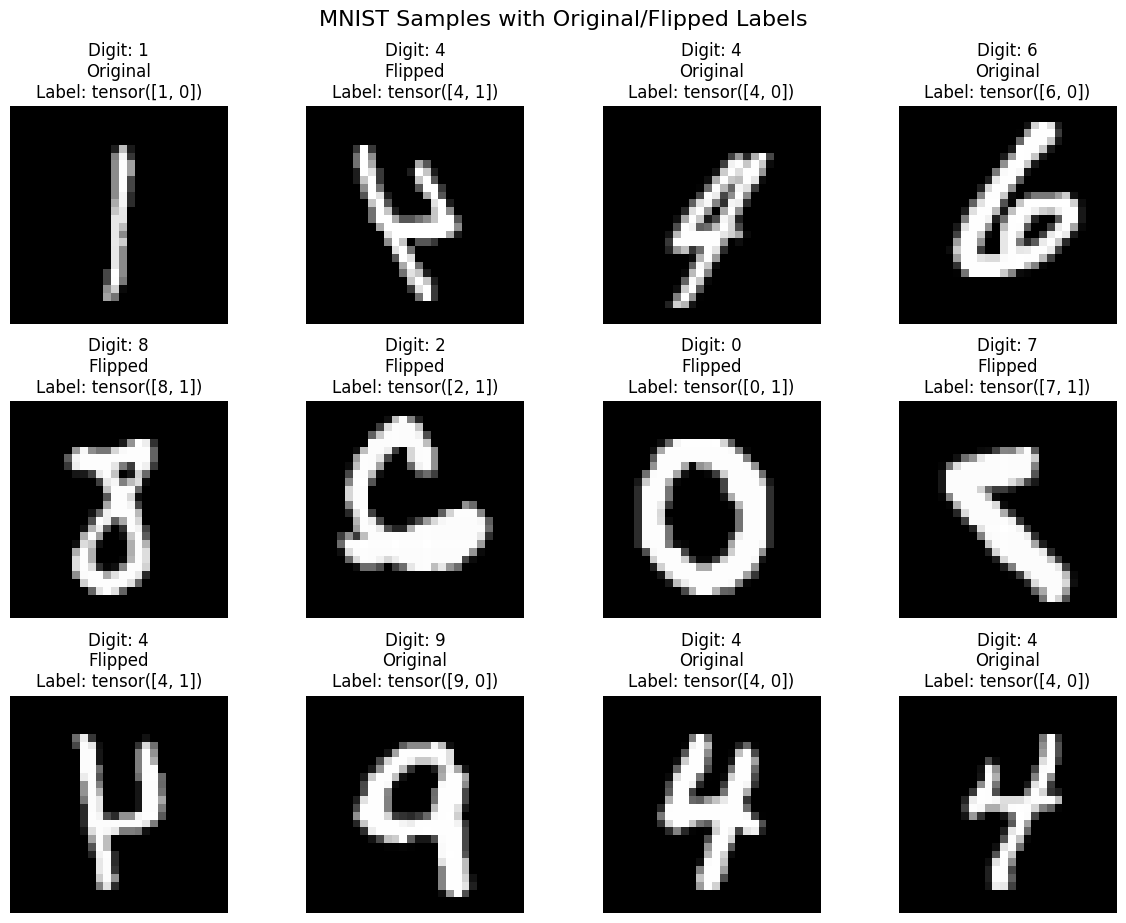

In [38]:
print("Training Set Samples:")
plot_samples(train_split)

# Plot samples from test set
print("\nTest Set Samples:")
plot_samples(flip_test_dataset)

## 1.4 Implement a CNN classifier

The classifier should output whether a sample (MNIST image) is flipped or not.

Provide evidence of the performance of your classifier (training curves, confusion matrices, and anything else you think is pertinent) and discuss what the evidence is telling you about your chosen model, the dataset, and the training.

In [40]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [43]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.5)

    self.fc1 = nn.Linear(128 * 3 * 3, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  # 32x14x14
    x = self.pool(F.relu(self.conv2(x)))  # 64x7x7
    x = self.pool(F.relu(self.conv3(x)))  # 128x3x3

    x = x.view(-1, 128 * 3 * 3)  # Flatten
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 420,994


In [45]:
def create_flip_loader(dataset, batch_size, shuffle=True):
    flip_data = []
    flip_labels = []

    for img, label in dataset:
        flip_data.append(img)
        flip_labels.append(label[1].item())

    flip_dataset = torch.utils.data.TensorDataset(torch.stack(flip_data), torch.tensor(flip_labels, dtype=torch.long))
    return torch.utils.data.DataLoader(flip_dataset, batch_size=batch_size, shuffle=shuffle)

In [46]:
flip_train_loader = create_flip_loader(train_split, batch_size=64, shuffle=True)
flip_val_loader = create_flip_loader(val_split, batch_size=64, shuffle=False)
flip_test_loader = create_flip_loader(flip_test_dataset, batch_size=64, shuffle=False)

In [47]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), 100 * correct / total, all_preds, all_labels

In [48]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, flip_train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, flip_val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

Starting training...
Epoch [1/20]
Train Loss: 0.1055, Train Acc: 95.64%
Val Loss: 0.0514, Val Acc: 98.04%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.0454, Train Acc: 98.42%
Val Loss: 0.0242, Val Acc: 99.08%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.0363, Train Acc: 98.72%
Val Loss: 0.0237, Val Acc: 99.17%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.0330, Train Acc: 98.81%
Val Loss: 0.0262, Val Acc: 99.08%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.0310, Train Acc: 98.96%
Val Loss: 0.0529, Val Acc: 98.12%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.0281, Train Acc: 99.03%
Val Loss: 0.0238, Val Acc: 99.10%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.0253, Train Acc: 99.13%
Val Loss: 0.0252, Val Acc: 99.02%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.

## 1.5 Hyperparameter strategy

Choose one hyperparameter to tune with three different values. Why did you choose this hyperparameter?

If you had more time, what other hyperparameters would you explore to improve the performance of your network? Choose two.

In [ ]:
learning_rates = [0.0001, 0.001, 0.01]
results = {}

for lr in learning_rates:
    print(f"\n{'='*50}")
    print(f"Training with Learning Rate: {lr}")
    print(f"{'='*50}")

    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    num_epochs = 10

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, flip_train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = validate(model, flip_val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if (epoch + 1) % 3 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    test_loss, test_acc, _, _ = validate(model, flip_test_loader, criterion, device)

    results[lr] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'final_test_acc': test_acc,
        'final_val_acc': val_accs[-1]
    }

    print(f'Final Test Accuracy: {test_acc:.2f}%')


Training with Learning Rate: 0.0001
Epoch [3/10] - Train Acc: 98.47%, Val Acc: 98.92%
Epoch [6/10] - Train Acc: 99.03%, Val Acc: 99.10%
Epoch [9/10] - Train Acc: 99.30%, Val Acc: 99.37%
Final Test Accuracy: 99.33%

Training with Learning Rate: 0.001


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

colors = ['blue', 'red', 'green']
for i, lr in enumerate(learning_rates):
    # Training Loss
    axes[0,0].plot(results[lr]['train_losses'], color=colors[i], label=f'LR={lr}', marker='o')
    # Validation Loss
    axes[0,1].plot(results[lr]['val_losses'], color=colors[i], label=f'LR={lr}', marker='s')
    # Training Accuracy
    axes[1,0].plot(results[lr]['train_accs'], color=colors[i], label=f'LR={lr}', marker='o')
    # Validation Accuracy
    axes[1,1].plot(results[lr]['val_accs'], color=colors[i], label=f'LR={lr}', marker='s')

axes[0,0].set_title('Training Loss')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].set_title('Validation Loss')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,0].set_title('Training Accuracy')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy (%)')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].set_title('Validation Accuracy')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy (%)')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("LEARNING RATE COMPARISON SUMMARY")
print("="*60)
print(f"{'Learning Rate':<15} {'Final Val Acc':<15} {'Final Test Acc':<15}")
print("-"*45)
for lr in learning_rates:
    val_acc = results[lr]['final_val_acc']
    test_acc = results[lr]['final_test_acc']
    print(f"{lr:<15} {val_acc:<15.2f} {test_acc:<15.2f}")

I chose Learning Rate since it has a direct impact on convergence. Too high and the model overshoots optimal weights, too low and training is very slow.
The effects are easily observed as you can immediately see the impact in training curves. In addition, it affects both training speed and final performance quality.

If I had more time, I would explore these two additional hyperparameters:

Dropout Rate since it controls overfitting vs underfitting balance.

Batch Size since it affects gradient estimation quality and training stability. Smaller batches provide more frequent updates but noisier gradients while larger batches give smoother training but slower convergence. In addition, it can significantly impact final performance.

---

# Task 2

## 2.1 Generative modelling

Use the MNIST dataset you created in task 1 to implement two generative models (you can reuse code from the lectures): a VAE, and a GAN.

Once implemented, train each of them for 10 mins (a few epochs). Use the models to generate new samples (they do not need to be good, of course) and plot them.

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.activation = nn.LeakyReLU(0.2)

    # forward method
    def forward(self, z):
        x = self.activation(self.fc1(z))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return torch.tanh(self.fc4(x)) # Our input is in the range [-1, 1]

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3) # We regularise the discriminator by adding dropout so it doesn't memorise
                                       # the training data

    # forward method
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x)) # Our discriminator is a binary classifier with probability between [0, 1]


# Instantiate model and send to device
z_dim = 128
x_dim = 28*28
G = Generator(z_dim, x_dim).to(device)
D = Discriminator(x_dim).to(device)

G(torch.randn(10, z_dim).to(device)).shape, D(torch.randn(10, x_dim).to(device)).shape

In [ ]:
lr = 0.0002
G_optimiser = torch.optim.Adam(G.parameters(), lr=lr)
D_optimiser = torch.optim.Adam(D.parameters(), lr=lr)

In [ ]:
def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train(), G.eval()
    D_optimiser.zero_grad()

    bs = x.shape[0]

    # Real data reshaped -- label for all real samples is 1
    x_real, y_real = x.view(-1, 28*28), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    # Training loss for real data
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # Sample vector and generation of fake data -- label for all fake samples is 0
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    # Training loss for fake data
    D_output = D(x_fake.detach())
    D_fake_loss = criterion(D_output, y_fake)

    # Combine the losses
    D_loss = D_real_loss + D_fake_loss

    # Backpropagate and model update
    D_loss.backward()
    D_optimiser.step()

    return D_loss.item()

In [ ]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimiser.zero_grad()

    bs = x.shape[0]

    # Sample vector and generation of fake data
    z = torch.randn(bs, z_dim).to(device)
    x_fake = G(z)

    # To "fool" the discriminator, fake data labels are set to 1
    y = torch.ones(bs, 1).to(device)

    # Training loss of the generator
    D_output = D(x_fake)
    G_loss = criterion(D_output, y)

    # Backpropagate and model update
    G_loss.backward()
    G_optimiser.step()

    return G_loss.item()

In [ ]:

criterion = nn.BCELoss()

In [ ]:
n_epoch = 100
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
    d_loss_epoch, g_loss_epoch = 0, 0
    logs = {}

    # Loop through batch and train discriminator then generator
    for batch_idx, (x, _) in enumerate(train_loader):
        d_loss_epoch += D_train(x) # Train discriminator
        g_loss_epoch += G_train(x) # Train generator

    # Update logs
    logs['D_Loss'] = d_loss_epoch / len(train_loader)
    logs['G_Loss'] = g_loss_epoch / len(train_loader)
    liveloss.update(logs)
    liveloss.draw()

    # Save every 20th epochs
    if(np.mod(epoch, 20) == 0):
        torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

Then, answer the following:

## 2.2

What is the main idea behind a VAE? How does it generate new samples from a training dataset? Explain how it is different than a regular autoencoder, and what is the role that the KL loss term plays in it. Refer to the code you implement in 2.1 in your explanations.


In [ ]:
# Add as many text and code blocks as needed to answer the question here

## 2.3
In GANs there are two competing networks, what role do they play in the training process? And how do they learn to generate samples differently from a VAE? Refer to the code you implement in 2.1 in your explanations.

Explain why the loss evolution for generator and discriminator oscillate during training. Is there a way to clearly determine when training is complete?

In [ ]:
# Add as many text and code blocks as needed to answer the question here

---

# Task 3

Answer the following questions:

## 3.1 RNNs
Given an RNN, with a single layer, that has been trained and is used to generate new outputs, like the one in the figure below:

<center><img src="https://drive.google.com/uc?id=1GmEyTghDKdkBx0gbFrw_KOn6zuKbNaHc" width="500"/></center>

[link to the figure](https://drive.google.com/file/d/1GmEyTghDKdkBx0gbFrw_KOn6zuKbNaHc/view?usp=share_link) in case you cannot see it in the notebook.

<br>

If the dimension of my hidden vector is 151, and the dimension of my input and output is 101, what are the sizes of the matrices $W_{hh}$, $W_{xh}$ and $W_{hy}$?

$W_{hh}$:
- 151 rows
- 151 columns

$W_{xh}$:
- 151 rows
- 101 columns

$W_{hy}$:
- 101 rows
- 151 columns

W_hh are hidden to hidden weights. It takes hidden state h0 with dimension 151 and produces part of the input to the tanh activation and must map from hidden dimension to hidden dimension.

W_xh are input-to-hidden weights. It takes input x1 with dimension 101 and produces part of the input to the tanh activation and must map from input dimension to hidden dimension.

W_yh are hidden-to-output weights. Takes hidden state h1 with dimension 151 and produces output y1 with dimension 101. It must map from hidden dimension to output dimension.

## 3.2 LSTMs
Indicate which of the following statements is False, and explain why:

a) LSTMs have two vectors that are passed: the cell state and the hidden state. The cell state is responsible for keeping 'longer term' memory in the system.

b) The activations functions of the various gates in an LSTM are tanh, so that they can act as 'continuous switches' to pass or not pass information.

The false statement is b.

Statement A is true since LSTMs pass both cell state and hidden state between time steps. Aswell it is true that the cell state is responsible for long term memory of the model while hidden state is responsilbe for working memory.

Statement B is false as not all activation functions in a LSTM are tanh. The Gate activations are performed using the sigmoid function not tanh.

## 3.3 Transformers

- In the attention layers of a transformer, how are the keys, queries, and values calculated and combined? Explain what elements of the layer are learned during training.

All three parameters are similar in structure, with each word in the sequence represented by a vector. Three separatly learned weights tranform each of the Queries, Keys and Values respectively.

The attention mechanism follows this formula: Attention(Q,K,V) = softmax(QK^T / √d_k) × V

where dividing by √d_k prevents extremely large values that would saturate the softmax. Softmax is applied normalise the probabilities and then the  attention weights are multiplied by values to get final output.

This calculation happens across multiple heads. Each head has its own W_Q, W_K, W_V matrices where the outputs are concatenated and passed through a final learned projection W_O.

The input is multiplied by the Query matrix to map it to the query space, which represents what information each word is looking for from other words in the sequence. Multiplying the input with the Key matrix maps it to the key space, which represents what information each word has available to offer. A dot product is taken between the query and key matrices to compute compatibility scores. If the result is large it indicates that one word contains information that another word finds relevant. These scores are normalised with softmax to create attention weights, which are then multiplied by the Value vectors. The Value vectors contain the actual information content that gets retrieved and combined. This process allows each word to create a new contextual representation by gathering relevant information from other words in the sequence based on learned attention patterns.

- After data has gone through the final linear layer of the translation transformer introduced in the paper 'Attention is all you need', what is the shape (dimensions) of the data and how is it converted into words (or tokens)?

After the final layer the shape of the data is (batch_size, target_sequence_length, vocabulary_size).

Each position in the output sequence holds a vector of scores over the entire vocabulary. These scores are passed through a softmax to produce probability distributions over possible next tokens. It then selects actual token IDs from these distributions either by taking the highest probability token or by sampling strategies. These IDs are then mapped back into words or subword units using the model's vocabulary and tokeniser.